In [1]:
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 15, 'lines.linewidth': 2, 'axes.spines.top': False, 'axes.spines.right': False, 'savefig.dpi': 1200})
import numpy as np

# Two Box Foraging Experiment

There are two boxes in the environment, each uses its own color cue to indicate food availability. An agent can move to different locations and push button if it is at a box.

In [2]:
from boxforage.environment import ForagingEnvironment
from boxforage.utils import plot_box_states, plot_experience

env = ForagingEnvironment(boxes_spec={'num_boxes': 2, 'p_appear': 0.2})

## Gameplay of a random agent

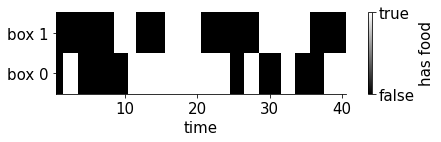

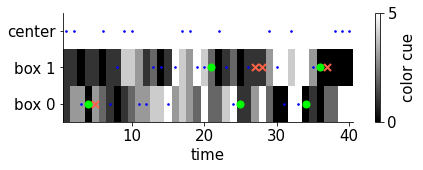

In [3]:
num_steps = 40
trial = env.run_one_trial(num_steps=num_steps)

fig, ax = plot_box_states(trial)
fig, ax = plot_experience(trial)